In [3]:
import csv
import os
import pandas as pd
import matplotlib.pylab as plt
from matplotlib import pyplot
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet

In [4]:
os.chdir("D://BIT_study_related//Thesis//Data_Monthly")

In [5]:
!dir

 Volume in drive D is Seagate Backup Plus Drive
 Volume Serial Number is 5059-4187

 Directory of D:\BIT_study_related\Thesis\Data_Monthly

05/09/2023  11:25 AM    <DIR>          .
05/06/2023  03:22 PM    <DIR>          ..
05/08/2023  10:18 AM    <DIR>          .ipynb_checkpoints
05/01/2023  01:49 PM         5,322,673 2015_Winter.tif
05/01/2023  04:12 PM           310,757 2015_Winter.tif.aux.xml
05/08/2023  01:05 PM             2,394 CO2_date_index - Copy.csv
05/09/2023  11:24 AM             3,571 CO2_date_index.csv
05/09/2023  11:25 AM         1,664,824 CO2_TimeSeries.ipynb
05/08/2023  10:10 AM           243,572 CO2_Time_Series_forecasting_RNN-LSTM.ipynb
04/18/2023  07:07 AM             5,494 CO2_values.csv
05/08/2023  01:25 PM             1,993 detrended.csv
05/01/2023  07:50 PM    <DIR>          DINCAE
05/01/2023  11:21 AM    <DIR>          DINEOF
05/01/2023  11:22 AM    <DIR>          Dineof_Output
05/01/2023  02:50 PM    <DIR>          Dineof_Output - Copy
05/01/2023  04:11 PM    

In [8]:
df=pd.read_csv('SIF_values.csv')
df.tail()

,system:index,maximum,mean,minimum,pixelcount,stddev
94,SIF_2022_9,1.137713,0.291574,-0.869132,1882,0.172338
95,SIF_2022_10,0.810936,0.236563,-0.276921,3333,0.121175
96,SIF_2022_11,0.936851,0.206334,-0.351089,3852,0.134163
97,SIF_2022_12,0.521082,0.143819,-0.379590,2345,0.096504
98,SIF_2023_1,0.943314,0.142977,-0.839472,4593,0.115535


In [9]:
df.loc[:,'system:index'] = df['system:index'].str.slice(4,)
df['system:index'].tail()
df.loc[:,'system:index'] = df['system:index'].str.replace('_', '-')
df = df.loc[:,['system:index','mean','stddev','pixelcount']]
df

,system:index,mean,stddev,pixelcount
0,2014-10,0.295534,0.146023,575
1,2014-11,0.220737,0.118876,930
2,2014-12,0.140735,0.112187,1313
3,2015-1,0.102476,0.113561,580
4,2015-2,0.100061,0.116195,1329
...,...,...,...,...
94,2022-9,0.291574,0.172338,1882
95,2022-10,0.236563,0.121175,3333
96,2022-11,0.206334,0.134163,3852
97,2022-12,0.143819,0.096504,2345


In [10]:
df.to_csv('D:\\BIT_study_related\\Thesis\\Data_Monthly\\SIF_date_index.csv')

In [11]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
df = pd.read_csv('SIF_date_index.csv',parse_dates=['system:index'], date_parser=dateparse)
df.drop('Unnamed: 0',axis=1,inplace=True)
df.rename(columns = {'system:index':'Months'}, inplace = True)
#df.set_index('Months', inplace=True)
print ('\n Parsed Data:')
print (df.head())


 Parsed Data:
      Months      mean    stddev  pixelcount
0 2014-10-01  0.295534  0.146023         575
1 2014-11-01  0.220737  0.118876         930
2 2014-12-01  0.140735  0.112187        1313
3 2015-01-01  0.102476  0.113561         580
4 2015-02-01  0.100061  0.116195        1329


C:\Users\shrey\AppData\Local\Temp\ipykernel_17864\1257115112.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')


In [13]:
df['year'] = df['Months'].dt.year
df

,Months,mean,stddev,pixelcount,year
0,2014-10-01,0.295534,0.146023,575,2014
1,2014-11-01,0.220737,0.118876,930,2014
2,2014-12-01,0.140735,0.112187,1313,2014
3,2015-01-01,0.102476,0.113561,580,2015
4,2015-02-01,0.100061,0.116195,1329,2015
...,...,...,...,...,...
94,2022-09-01,0.291574,0.172338,1882,2022
95,2022-10-01,0.236563,0.121175,3333,2022
96,2022-11-01,0.206334,0.134163,3852,2022
97,2022-12-01,0.143819,0.096504,2345,2022


In [55]:
#Convert to timeseries
ts = df['mean']
ts.head(10)

Months
2014-10-01    0.295534
2014-11-01    0.220737
2014-12-01    0.140735
2015-01-01    0.102476
2015-02-01    0.100061
2015-03-01    0.131698
2015-04-01    0.189036
2015-05-01    0.239306
2015-06-01    0.273385
2015-07-01    0.258510
Name: mean, dtype: float64

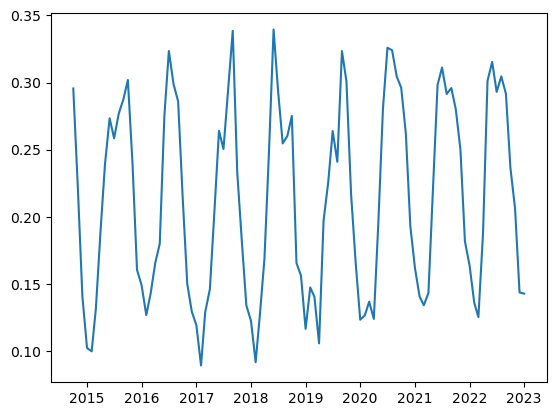

In [59]:
plt.plot(ts)

In [63]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    #rolmean = pd.rolling_mean(timeseries, window=12)
    rolmean = pd.Series(timeseries).rolling(window=12).mean()
    #rolstd = pd.rolling_std(timeseries, window=12)
    rolstd = pd.Series(timeseries).rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

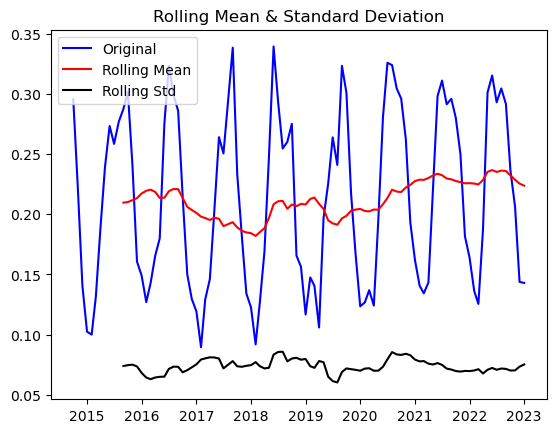

Results of Dickey-Fuller Test:
Test Statistic                 -1.612833
p-value                         0.476489
#Lags Used                     10.000000
Number of Observations Used    88.000000
Critical Value (1%)            -3.506944
Critical Value (5%)            -2.894990
Critical Value (10%)           -2.584615
dtype: float64


In [64]:
test_stationarity(ts)

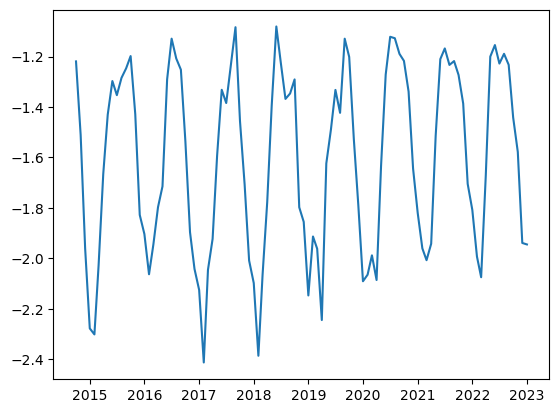

In [65]:
#MAKING TS STATIONARY

ts_log = np.log(ts)
plt.plot(ts_log)

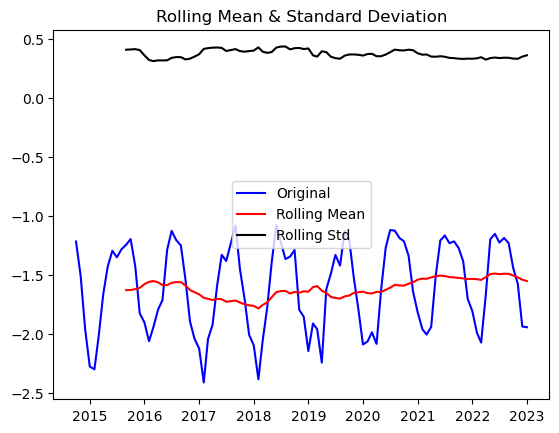

Results of Dickey-Fuller Test:
Test Statistic                 -1.523990
p-value                         0.521612
#Lags Used                     10.000000
Number of Observations Used    88.000000
Critical Value (1%)            -3.506944
Critical Value (5%)            -2.894990
Critical Value (10%)           -2.584615
dtype: float64


In [66]:
test_stationarity(ts_log)

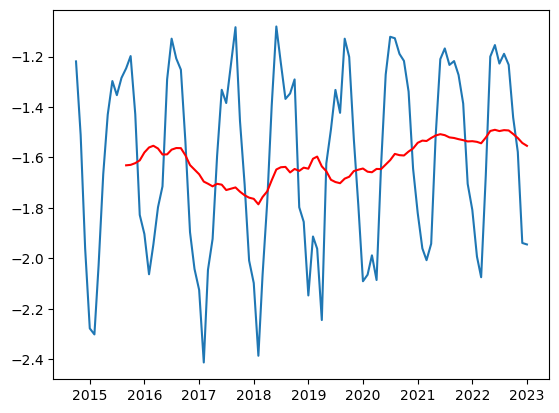

In [67]:
#Smoothing
moving_avg = pd.Series(ts_log).rolling(window=12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [68]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(5)

Months
2014-10-01   NaN
2014-11-01   NaN
2014-12-01   NaN
2015-01-01   NaN
2015-02-01   NaN
Name: mean, dtype: float64

In [69]:
ts_log_moving_avg_diff.dropna(inplace=True)
ts_log_moving_avg_diff.head(5)

Months
2015-09-01    0.384756
2015-10-01    0.431620
2015-11-01    0.194213
2015-12-01   -0.216563
2016-01-01   -0.323461
Name: mean, dtype: float64

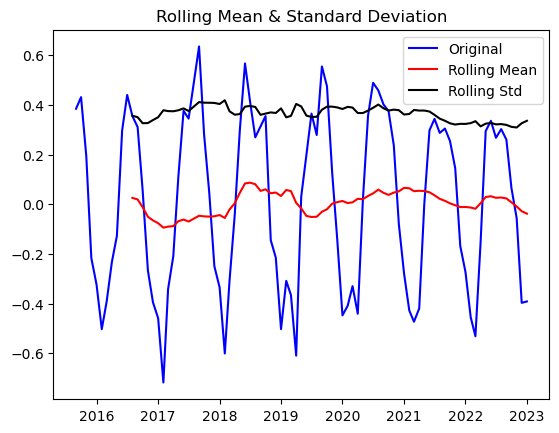

Results of Dickey-Fuller Test:
Test Statistic                 -2.362624
p-value                         0.152564
#Lags Used                     10.000000
Number of Observations Used    77.000000
Critical Value (1%)            -3.518281
Critical Value (5%)            -2.899878
Critical Value (10%)           -2.587223
dtype: float64


In [70]:
#TEST STATIONARITY AGAIN
test_stationarity(ts_log_moving_avg_diff)

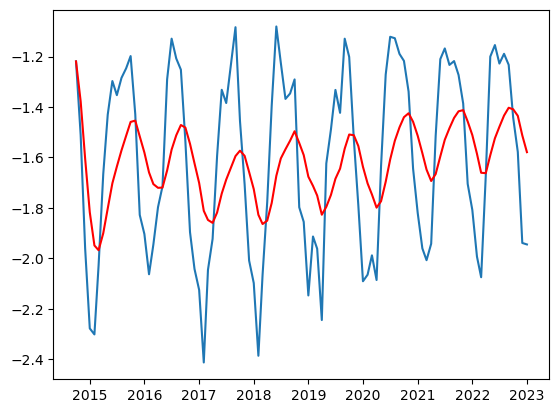

In [71]:
expwighted_avg = ts_log.ewm(span=12).mean() 
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

In [25]:
df['year'] = df['Months'].dt.year
df

,Months,mean,year
0,2014-10-01,0.295534,2014
1,2014-11-01,0.220737,2014
2,2014-12-01,0.140735,2014
3,2015-01-01,0.102476,2015
4,2015-02-01,0.100061,2015
...,...,...,...
94,2022-09-01,0.291574,2022
95,2022-10-01,0.236563,2022
96,2022-11-01,0.206334,2022
97,2022-12-01,0.143819,2022


In [14]:
df = df.rename(columns={'mean': 'y', 'Months':'ds'})

<Axes: >

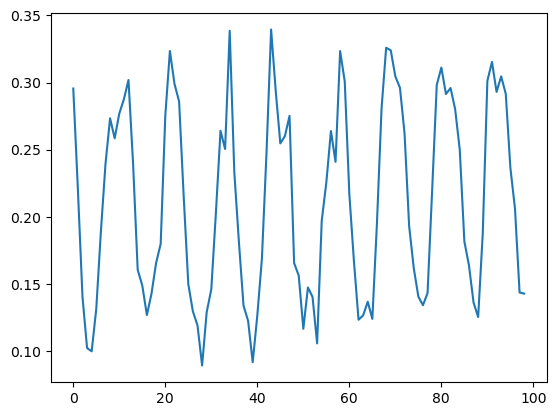

In [26]:
df.dropna(inplace=True)
df['mean'].plot()

In [28]:
result=seasonal_decompose(df, model='multiplicable', period = 12)

TypeError: float() argument must be a string or a real number, not 'Timestamp'

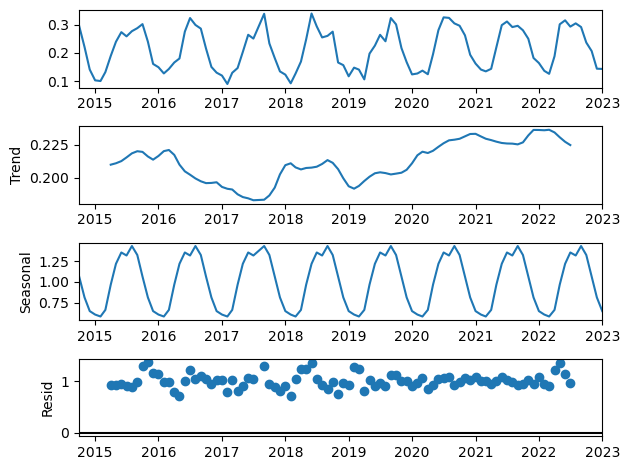

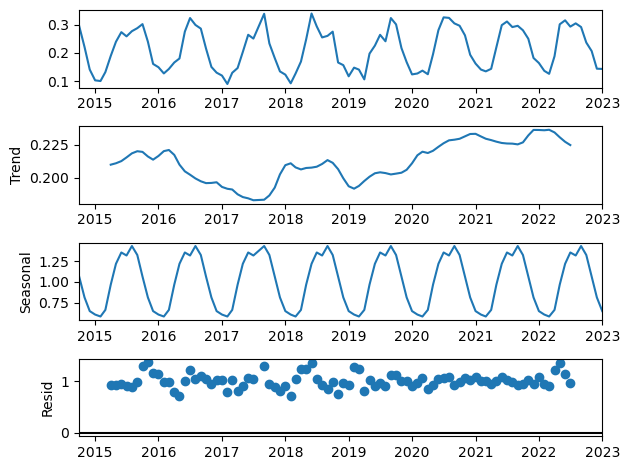

In [26]:
result.plot()

In [27]:
import pandas as pd
import numpy as np
df=df.dropna()
print('Shape of data',df.shape)
df.head()
df

Shape of data (99, 1)


,mean
system:index,
2014-10-01,0.295534
2014-11-01,0.220737
2014-12-01,0.140735
2015-01-01,0.102476
2015-02-01,0.100061
...,...
2022-09-01,0.291574
2022-10-01,0.236563
2022-11-01,0.206334


In [29]:
df.rename(columns = {'system:index':'Months'}, inplace = True)
df

,mean
system:index,
2014-10-01,0.295534
2014-11-01,0.220737
2014-12-01,0.140735
2015-01-01,0.102476
2015-02-01,0.100061
...,...
2022-09-01,0.291574
2022-10-01,0.236563
2022-11-01,0.206334


In [30]:
from statsmodels.tsa.stattools import adfuller
def ad_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)
ad_test(df)

1. ADF :  -1.6128328193180215
2. P-Value :  0.47648871849339675
3. Num Of Lags :  10
4. Num Of Observations Used For ADF Regression: 88
5. Critical Values :
	 1% :  -3.506944401824286
	 5% :  -2.894989819214876
	 10% :  -2.584614550619835


In [31]:
def ad_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)
ad_test(result.resid.dropna())

1. ADF :  -6.789589172174551
2. P-Value :  2.3834488968112404e-09
3. Num Of Lags :  5
4. Num Of Observations Used For ADF Regression: 81
5. Critical Values :
	 1% :  -3.5137900174243235
	 5% :  -2.8979433868293945
	 10% :  -2.5861907285474777


<AxesSubplot:xlabel='system:index'>

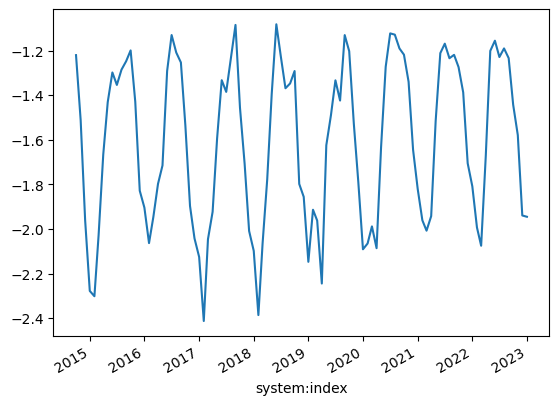

In [32]:
ts_log = np.log(df['mean'])
ts_log.plot()

In [33]:
ts_log.dropna(inplace=True)
ad_test(ts_log)

1. ADF :  -1.5239902004258663
2. P-Value :  0.5216121192375549
3. Num Of Lags :  10
4. Num Of Observations Used For ADF Regression: 88
5. Critical Values :
	 1% :  -3.506944401824286
	 5% :  -2.894989819214876
	 10% :  -2.584614550619835


<AxesSubplot:xlabel='system:index'>

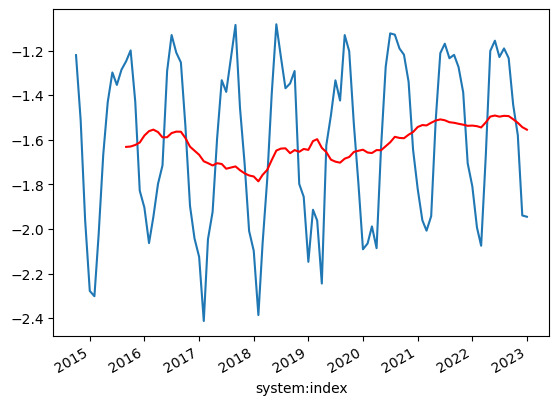

In [34]:
moving_avg = pd.Series(ts_log).rolling(window=12).mean()
ts_log.plot()
moving_avg.plot(color='red')

In [35]:
moving_avg.dropna(inplace=True)
ad_test(moving_avg)

1. ADF :  -1.6812258416975758
2. P-Value :  0.44081051953400285
3. Num Of Lags :  1
4. Num Of Observations Used For ADF Regression: 86
5. Critical Values :
	 1% :  -3.5087828609430614
	 5% :  -2.895783561573195
	 10% :  -2.5850381719848565


In [36]:
differencing = ts_log - moving_avg
differencing.dropna(inplace=True)
differencing.head(5)

system:index
2015-09-01    0.384756
2015-10-01    0.431620
2015-11-01    0.194213
2015-12-01   -0.216563
2016-01-01   -0.323461
Name: mean, dtype: float64

In [37]:
ad_test(differencing)

1. ADF :  -2.3626241237030987
2. P-Value :  0.15256446289270442
3. Num Of Lags :  10
4. Num Of Observations Used For ADF Regression: 77
5. Critical Values :
	 1% :  -3.518281134660583
	 5% :  -2.899878185191432
	 10% :  -2.5872229937594873


In [38]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')
stepwise_fit = auto_arima(ts_log, trace= True, suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=84.999, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-6.029, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=10.619, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=382.917, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-36.995, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-51.879, Time=0.10 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=-59.992, Time=0.21 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=-63.764, Time=0.20 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=-64.031, Time=0.35 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=-64.353, Time=0.41 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-64.087, Time=0.24 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=-61.980, Time=0.32 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-58.651, Time=0.32 sec
 ARIMA(5,0,2)(0,0,0)[0] intercept   : AIC=-60.233, Tim

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   99
Model:               SARIMAX(4, 0, 1)   Log Likelihood                  39.177
Date:                Tue, 18 Apr 2023   AIC                            -64.353
Time:                        15:51:56   BIC                            -46.187
Sample:                             0   HQIC                           -57.003
                                 - 99                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.6903      0.173     -3.982      0.000      -1.030      -0.350
ar.L1          1.2630      0.225      5.604      0.000       0.821       1.705
ar.L2         -0.4665      0.254     -1.836      0.066      -0.964       0.031
ar.L3         -0.0364      0.177     -0.206      0.837      -0.382       0.310
ar.L4         -0.1890      0.158     -1.195      0.232      -0.499       0.121
ma.L1         -0.4891      0.238     -2.054      0.040      -0.956      -0.022
sigma2         0.0257      0.004      6.164      0.000       0.018       0.034
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 1.21
Prob(Q):                              0.78   Prob(JB):                         0.55
Heteroskedasticity (H):               1.00   Skew:                            -0.26
Prob(H) (two-sided):                  1.00   Kurtosis:                         2.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [39]:
train = ts_log.iloc[:-30]
test = ts_log.iloc[-30:]
print(train.shape,test.shape)

(69,) (30,)


In [46]:
from statsmodels.tsa.arima.model import ARIMA
from numpy.linalg import LinAlgError
from sklearn.metrics import mean_squared_error

In [47]:
history = [x for x in train]
predictions = list()
#test.reset_index()

In [48]:
for t in range(len(test)):
    try:
        model = ARIMA(history, order=(4,0,1))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
    except (ValueError, LinAlgError):
        pass
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
rmse = mean_squared_error(test, predictions)**0.5
print('Test MSE: %.3f' % rmse)

predicted=-1.110253, expected=-1.127053
predicted=-1.249848, expected=-1.189067
predicted=-1.451748, expected=-1.216975
predicted=-1.584122, expected=-1.338815
predicted=-1.707711, expected=-1.644089
predicted=-1.923077, expected=-1.820405
predicted=-2.023777, expected=-1.960744
predicted=-2.054279, expected=-2.007500
predicted=-1.974932, expected=-1.942232
predicted=-1.822344, expected=-1.514415
predicted=-1.434833, expected=-1.210019
predicted=-1.171140, expected=-1.167543
predicted=-1.183799, expected=-1.232924
predicted=-1.364163, expected=-1.217694
predicted=-1.475423, expected=-1.272754
predicted=-1.574686, expected=-1.386275
predicted=-1.667153, expected=-1.704730
predicted=-1.906986, expected=-1.808268
predicted=-1.950630, expected=-1.993093
predicted=-2.021610, expected=-2.075078
predicted=-1.977279, expected=-1.671122
predicted=-1.585938, expected=-1.199966
predicted=-1.149078, expected=-1.154144
predicted=-1.135577, expected=-1.227522
predicted=-1.309942, expected=-1.188845


In [49]:
from math import sqrt
rms = sqrt(mean_squared_error(test, predictions))

In [70]:
df

,Months,maximum,mean,minimum,pixelcount,stddev,year
0,2014-10-01,0.743438,0.295534,-0.272396,575,0.146023,2014
1,2014-11-01,0.668596,0.220737,-0.230649,930,0.118876,2014
2,2014-12-01,0.514390,0.140735,-0.487072,1313,0.112187,2014
3,2015-01-01,0.690418,0.102476,-0.340367,580,0.113561,2015
4,2015-02-01,0.586696,0.100061,-0.324170,1329,0.116195,2015
...,...,...,...,...,...,...,...
94,2022-09-01,1.137713,0.291574,-0.869132,1882,0.172338,2022
95,2022-10-01,0.810936,0.236563,-0.276921,3333,0.121175,2022
96,2022-11-01,0.936851,0.206334,-0.351089,3852,0.134163,2022
97,2022-12-01,0.521082,0.143819,-0.379590,2345,0.096504,2022


# Welch's T-test

In [14]:
from scipy import stats

# Load the data
data = df

# Get a list of the unique months in the data
months = data['Months'].dt.month.unique()

# Loop through each month and perform Welch's t-test for 7 years of data
for month in months:
    # Get the summary statistics for this month for each year
    year_data = []
    for year in range(2014, 2023):
        year_month_data = data[(data['year'] == year) & (data['Months'].dt.month == month)]
        if not year_month_data.empty:
            year_mean = year_month_data.iloc[0]['mean']
            year_std = year_month_data.iloc[0]['stddev']
            year_nobs = year_month_data.iloc[0]['pixelcount']
            year_data.append((year_mean, year_std, year_nobs))
    
    # Only perform the t-test if we have data for at least two years
    if len(year_data) >= 2:
        # Perform Welch's t-test on the two values
        t, p = stats.ttest_ind_from_stats(year_data[0][0], year_data[0][1], year_data[0][2],
                                          year_data[1][0], year_data[1][1], year_data[1][2],
                                          equal_var=False)
        
        # Loop through remaining years to perform the test
        for i in range(1, len(year_data) - 1):
            t, p = stats.ttest_ind_from_stats(year_data[i][0], year_data[i][1], year_data[i][2],
                                              year_data[i+1][0], year_data[i+1][1], year_data[i+1][2],
                                              equal_var=False)
            # Print the results
            if p < 0.05:
                print(' ')
                #print('Significant difference found for {} {}: p-value = {}'.format(month, 2014+i, p))
            else:
                print('No significant difference found for {} {}: p-value = {}'.format(month, 2014+i, p))

 
No significant difference found for 10 2016: p-value = 0.2589274880152492
 
 
No significant difference found for 10 2019: p-value = 0.39745820302802815
 
 
 
 
No significant difference found for 11 2017: p-value = 0.10291864336427946
 
 
 
 
 
No significant difference found for 12 2016: p-value = 0.38882689344455756
 
No significant difference found for 12 2018: p-value = 0.08377765054688266
 
 
 
 
No significant difference found for 1 2016: p-value = 0.38500904008646886
No significant difference found for 1 2017: p-value = 0.15441203340895404
No significant difference found for 1 2018: p-value = 0.10787174438931349
 
No significant difference found for 1 2020: p-value = 0.6112179492557612
 
No significant difference found for 2 2016: p-value = 0.7253278402175289
 
 
 
No significant difference found for 2 2020: p-value = 0.21470046558788888
 
No significant difference found for 3 2016: p-value = 0.6757161904370093
 
No significant difference found for 3 2018: p-value = 0.5510128

In [ ]:
pip install pystan

In [ ]:
pip install fbprophet

In [14]:
from fbprophet import Prophet
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

ModuleNotFoundError: No module named 'fbprophet'

In [13]:
model = Prophet() #instantiate Prophet
model.fit(df)

NameError: name 'Prophet' is not defined